In [105]:
import astropy
from astropy.io import fits 
from astropy.stats import sigma_clip
from astropy.table import Table
from astropy.time import Time
from astropy.visualization import time_support
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.signal as sig
from scipy.stats import sigmaclip
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

In [2]:
def dataClean(filename): 
    """ This function will remove nan values from TESS 
        20 second lightcurve data and correct time values
        Stage: complete"""
    
    #Create an array of time and flux data with nans removed    
    with fits.open(filename, mode="readonly") as hdulist:
        raw_time = hdulist[1].data['TIME']
        raw_flux = hdulist[1].data['PDCSAP_FLUX']
        raw_err = hdulist[1].data['PDCSAP_FLUX_ERR']
    data = np.vstack((raw_time, raw_flux, raw_err))
    nonan_data = data[:, ~np.isnan(data).any(axis=0)]

    #Apply time correction 
    times = nonan_data[0]
    flux = nonan_data[1]
    error = nonan_data[2]
    t_corr = []
    for i in times:
        r = i + 2457000
        t_corr.append(r)
    time = Time(t_corr, format = 'jd', scale = 'utc')
    time.format = 'iso'
    
    #Create arrays of cleaned data
    time = np.array(time)
    flux = np.array(flux)
    err = np.array(error)
    
    #Return cleaned data
    return[time,flux,err]

In [3]:
def generate_Qcurve(cleaned_data):
    """ This function will take cleaned data and dataframes of quiescent light curve
    as well as flaring light curve values
    Stage: complete"""

    #Identify quiescent light curve
    flux_smooth = sig.savgol_filter(cleaned_data[1], 1400, 3) #my opinion of the best parameters for this data
    q_time = cleaned_data[0] # time associated w/ quiescent flux
    q_flux = sig.savgol_filter(cleaned_data[1],2000,3) # quiescent flux
    ind2 = np.where(q_flux) #index created to assure lengths of data sets are equal
    
    #Set and index variables
    fluxes = cleaned_data[1]
    times = cleaned_data[0]
    F_err = cleaned_data[2] 
    flux_list = fluxes[ind2]
    time_list = times[ind2]
    err_list = F_err[ind2]

    #Ensure lists are same size for flare and quiescent data & have same timestamps at same indices
    qIndex = np.where(q_time) 
    err_list = err_list[qIndex]
    q_time = times[qIndex]
    q_flux = sig.savgol_filter(flux_list[qIndex],2000,3)
    
    #Create dataframes of Quiescent and Flaring lightcurves
    quiescence = pd.DataFrame({
                            'Time': q_time,
                            'Quiescent Flux':q_flux
    })

    cd = pd.DataFrame({
                                'Time': time_list[qIndex],
                                'Flux':flux_list[qIndex],
                                'Flux Error': err_list[qIndex]
    })
    return[quiescence,cd]

In [4]:
def qgen(cleaned_data):
    ydat = cleaned_data[1]
    xdat = cleaned_data[0]
    flux = pd.Series(ydat)
    roll = flux.rolling(3).median()
    roll2 = roll.rolling(6).median()
    roll3 = roll2.rolling(100).median()
    

    lower = roll3.quantile(0.0)
    upper = roll3.quantile(0.95)
    rclip = roll3.clip(lower=lower,upper=upper)
    rclip2 = rclip.clip(lower=lower,upper=upper)
    rclip3 = rclip2.clip(lower=lower,upper=upper)
    rclip4 = rclip3.clip(lower=lower,upper=upper)

    quiescence = pd.DataFrame({
                            'Time': xdat,
                            'Quiescent Flux':rclip4
    })

    cd = pd.DataFrame({
                            'Time': xdat,
                            'Flux':ydat,
                            'Flux Error':cleaned_data[2]
    })
    

    return[quiescence,cd]

In [5]:
def find_ix_ranges(ix, buffer=False):
    """ Finds indexes in the range.
    
        From MC GALEX function defs"""
    
    foo, bar = [], []
    for n, i in enumerate(ix):
        if len(bar) == 0 or bar[-1] == i-1:
            bar += [i]
        else:
            if buffer:
                bar.append(min(bar)-1)
                bar.append(max(bar)+1)
            foo += [np.sort(bar).tolist()]
            bar = [i]
        if n == len(ix)-1:
            if buffer:
                bar.append(min(bar)-1)
                bar.append(max(bar)+1)
            foo += [np.sort(bar).tolist()]
    return foo

In [6]:
def get_inff(lc, clipsigma=3, quiet=True, band='NUV',
             binsize=20.):
    """ Calculates the Instantaneous Non-Flare Flux values.
    
        From MC GALEX function defs"""
    
    sclip = sigma_clip(np.array(lc['Flux']), sigma=clipsigma)
    inff = np.ma.median(sclip)
    inff_err = np.sqrt(inff*len(sclip)*binsize)/(len(sclip)*binsize)
    if inff and not quiet:
        print('Quiescent at {m} AB mag.'.format(m=gt.counts2mag(inff, band)))
    return inff, inff_err

In [7]:
def find_flare_ranges(curve,q_curve,sig,quiescence=None):
    """This function will run through the data to find 
    flares and ranges of flares. This function will return
    a table of flares ranges. 
    
    Adapted from MC GALEX function defs.
    Stage: complete"""
    
    tranges = [[min(curve['Time']), max(curve['Time'])]] 
    if not quiescence:
        q, q_err = get_inff(curve)
    else:
        q, q_err = quiescence
    flare_ranges = []
    for trange in tranges:
        ix = np.where(((np.array(curve['Flux'].values)-(sig*np.array(curve['Flux Error'].values)) >= q_curve['Quiescent Flux'])))[0]
        flareFlux = ix
        if not len(ix):
            continue
        flux_ix = []
        
        for ix_range in find_ix_ranges(ix):
            # go backwards
            consec = 0 
            err = curve.iloc[ix_range[0]]['Flux Error'] 
            
            #while flux - err > quiescence, find 2 consecutive points withing quiescent curve
            while any(curve.iloc[ix_range[0]]['Flux']-err >= q_curve['Quiescent Flux']) and ix_range[0] > 0 or (consec < 1 and ix_range[0] >0):
                err = curve.iloc[ix_range[0]]['Flux Error']

                if any(curve.iloc[ix_range[0]]['Flux']- err < q_curve['Quiescent Flux']) :
                    consec +=1
                else: 
                    consec = 0
                if (curve.iloc[ix_range[0]+1]['Time']-curve.iloc[ix_range[0]]['Time']) > 1000: 
                    break               
                ix_range = [ix_range[0] - 1] + ix_range
                
                # go forwards
            consec = 0 
            err = curve.iloc[ix_range[-1]]['Flux Error']
            while any(curve.iloc[ix_range[-1]]['Flux']-err >= q_curve['Quiescent Flux']) and ix_range[-1] != len(curve)-1 or (consec <1 and ix_range[:-1]!= len(curve)-1):
                err = curve.iloc[ix_range[-1]]['Flux Error']
                if any(curve.iloc[ix_range[-1]]['Flux']-err < q_curve['Quiescent Flux']):
                    consec += 1
                else: 
                    consec = 0
                if curve.iloc[ix_range[-1]+1]['Time']-curve.iloc[ix_range[-1]]['Time'] > 1000: 
                    break
                ix_range = ix_range + [ix_range[-1] + 1]
                
            flux_ix += ix_range
        ix = np.unique(flux_ix)
        flare_ranges += find_ix_ranges(list(np.array(ix).flatten()))
    return(flare_ranges,flareFlux)

                

In [8]:
def refine_flare_ranges(curve,q_curve, sig=3., flare_ranges=None):
    """ Identify the start and stop indexes of a flare event after
    refining the INFF by masking out the initial flare detection indexes. 
    From MC GALEX function defs."""
    time_support()
    if not flare_ranges:
        flare_ranges, _ = find_flare_ranges(curve, q_curve, sig)
    flare_ix = list(itertools.chain.from_iterable(flare_ranges))
    quiescience_mask = [False if i in flare_ix else True for i in
                        np.arange(len(curve['Time']))]
    quiescence = q_curve
    quiescence_err = (np.sqrt(curve['Flux'][quiescience_mask].sum())/curve['Flux'].sum())
    flare_ranges, flare_3sigs = find_flare_ranges(curve,q_curve,
                                                  quiescence=(quiescence,
                                                              quiescence_err),
                                                  sig=sig)
    flare_ix = list(itertools.chain.from_iterable(flare_ranges))
    not_flare_ix = list(set([x for x in range(len(curve['Time']))]) - set(flare_ix))
    
    
    
    
    
    return flare_ranges, flare_ix

In [9]:
def energyCalculation(curve,flare_ranges,binsize=120/24/60, quiescence=None):
    """This function will calculate the energies of each flare.
        Stage: working, add errors"""
#energy calculation for 20 sec lightcurve binned to 2 mins (reccommended in Huber 2021)

    fluxes = curve['Flux'][flare_ranges[1]]
    distance_cm = 11*3.086e+18
    eff_width = 8.68e-7 

    energies = []
    q = []
    for i in fluxes:
        sclip = sigma_clip(fluxes,sigma=3)
        inff = np.ma.median(sclip)
        q.append(inff)
        
#subtract Q from Flare fluxes, Zero any values below INFF
    qsub = fluxes-q
    qsub[qsub<0] = 0
    qsub2 = qsub
#energy calculation                 
    for ix,flare in enumerate(flare_ranges[0]):
        flare_flux = qsub2[flare]
        int_flux = (binsize*flare_flux).sum()
        en = int_flux*eff_width
        energy = (4*np.pi*(distance_cm**2)*en)
        energies.append(energy)
        #NEXT: don't forget to calculate errors
       
    return(energies)

In [10]:
def plot_flares(flare_ranges):
    """ Plots flares from flare ranges"""
    for i,v in enumerate(flare_ranges[0]):
        t = (times[v])
        f = (fluxes[v])
        f.plot(xticks=t.index, yerr=err[v],xlabel=('Flare ID:',i))


In [11]:
def FlareTable(curve,flare_ranges,energies):
    """This function will build a table of all flares.
        Stage: complete"""
    
    #Generate quiescent and flaring curves in order to index time values
    times = curve['Time']
    
    #Create empty lists to use as columns for table

    tstart = []
    tstop = []
    duration = []
    energy = list(energies)
    
    #Populate Lists
    for flare in flare_ranges[0]:
        start_ix = times[flare[0]]
        stop_ix = times[flare[-1]]
        tstart.append(start_ix)
        tstop.append(stop_ix)
        duration.append(((times[flare[-1]]-times[flare[0]])).sec)


    #Label flares    
    flareID = list(range(1,183+1)) 
    
    #Build flare table
    flareTable = pd.DataFrame({
                                "ID": flareID,
                                "Start Time": tstart,
                                "Stop Time": tstop,
                                "Duration (s)": duration,
                                "Total Energy": energy
    })
    
    return(flareTable)
        

In [13]:
TESSDATA = '/Users/katborski/Documents/GitHub/AFPSC/TESS/tess2021232031932-s0042-0000000250081915-0213-a_fast-lc.fits'
cleaned_data = dataClean(TESSDATA)

dataset = qgen(cleaned_data)
q_curve = dataset[0]
curve = dataset[1]

ranges,flux = find_flare_ranges(curve,q_curve,3)

In [14]:
flare_ranges = refine_flare_ranges(curve,q_curve,sig=3.)


In [15]:
fe = curve['Flux Error'][flare_ranges[1]]
flux_error= pd.DataFrame({'Flux Error': fe})


In [29]:
energies = energyCalculation(curve,flare_ranges)
FT = FlareTable(curve,flare_ranges,energies)

#energy calculation still seems a bit high however it is much more reasonable now 

#NEW quiescence using qgen() function, gives 183 flares whereas generate_Qcurve() gives 166 flares 

In [17]:
times = curve['Time'][flare_ranges[1]]
fluxes = curve['Flux'][flare_ranges[1]]
err = curve['Flux Error'][flare_ranges[1]]
q = q_curve['Quiescent Flux'][flare_ranges[1]]



IndexError: index 182 is out of bounds for axis 0 with size 182

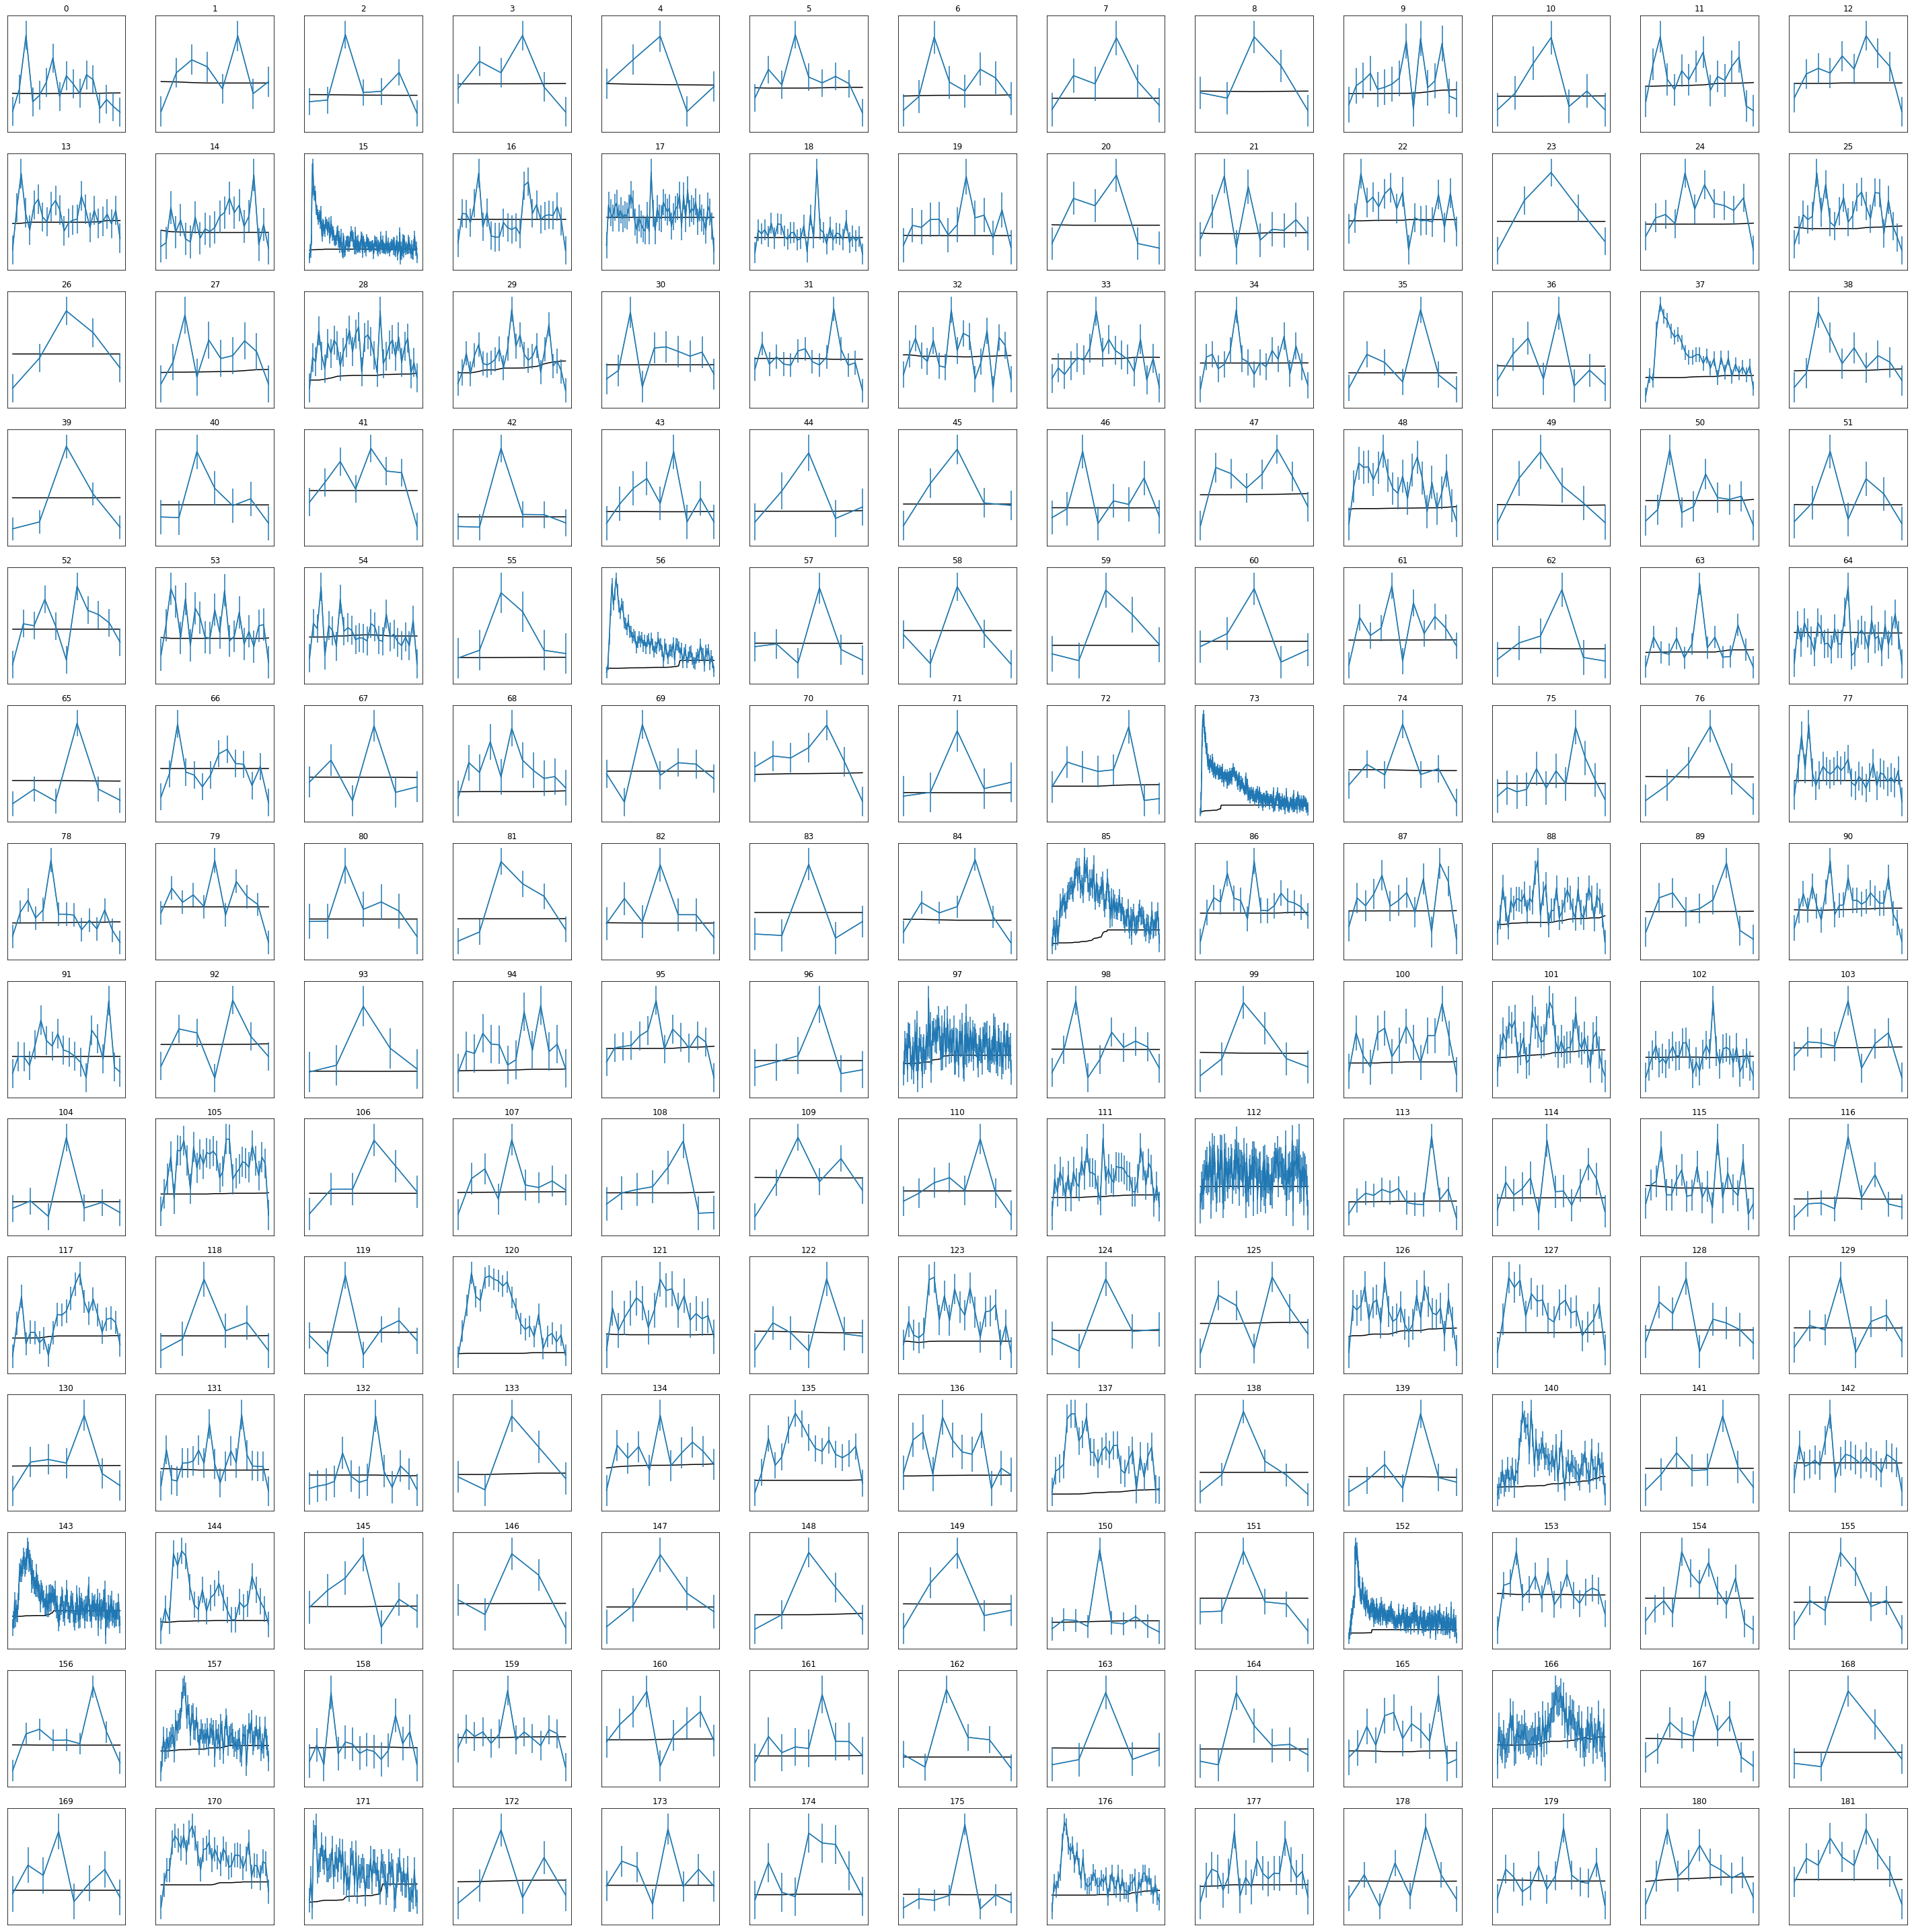

In [34]:
fig,ax = plt.subplots(14,13)
fig.set_size_inches(40,40)
fig.tight_layout()
for i,v in enumerate(flare_ranges[0]):
    t = (times[v])
    f = (fluxes[v])
    y_er = (err[v])
    quies = (q[v])
    ax.flat[i].plot(quies,color='black')
    ax.flat[i].plot(f,color='cadetblue')
    ax.flat[i].errorbar(t.index,f.values,yerr=y_er)
    plt.setp(ax, xticks=[], yticks=[]) #clearing out time/flux ticks for now to make graphs easier to look at
    ax.flat[i].set_title(i)

plt.show()
#fig.savefig(
#    'grid_of_flares_w_quiescence.jpg', dpi=1000, bbox_inches="tight", pad_inches=0
#)

In [98]:
tess_time= curve['Time']

In [120]:
#Adapted from Fleming et al 2022

#Calculate on-source time
#chunk 1: between TESS start observation time and first cutoff (2021-08-27 02:19:12.359)
#chunk 2: between 2021-09-03 17:52:28.664 and end of TESS observation time 
t1=tess_time[25489]-tess_time[0] #days
t2=tess_time[66883]-tess_time[25460] #days
ontimesec=(t1+t2)*24*60*60
ontimemin=ontimesec/60
ontimehour=ontimemin/60
print('Total Time on Source:',t1+t2,'days')
print('Total Time on Source:',ontimehour,'hours')
print('Total TIme on Source:',ontimemin,'minutes')
print('Total Time on Source:',ontimesec,'seconds')

Total Time on Source: 23.1474527195096 days
Total Time on Source: 555.5388652682304 hours
Total TIme on Source: 33332.331916093826 minutes
Total Time on Source: 1999939.9149656296 seconds


In [142]:
#Adapted from Fleming et al 2022

#number of flares from flare finding function
n_flares=182
#set sigma for uncertainties
sigma=1
flare_rt=n_flares/33332.331916093826
flare_rt_er= np.sqrt(n_flares)/33332.331916093826
rate_ = np.log10(flare_rt*60)
rate_err = np.log10((flare_rt + sigma*flare_rt_er)*60) - np.log10(flare_rt*60)
print(f'log10(#/hr) = {rate_} +/- {rate_err}')
print(f'Af Psc: {flare_rt} +/- {sigma*flare_rt_er} flares per minute')

log10(#/hr) = -0.48464305941619235 +/- 0.031054797171503112
Af Psc: 0.005460164037071918 +/- 0.0004047342861337079 flares per minute


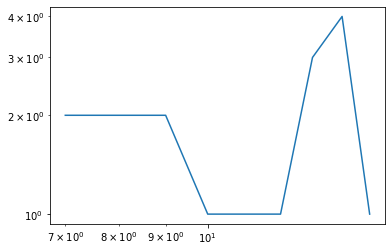

In [132]:
nfd = [7,9,10,11,12,13,14,15] #number of flares per day
freq = [2,2,1,1,1,3,4,1] # frequency of those flares in observation
plt.plot(nfd,freq)

Text(0, 0.5, 'Flare Rate log(#/hr)')

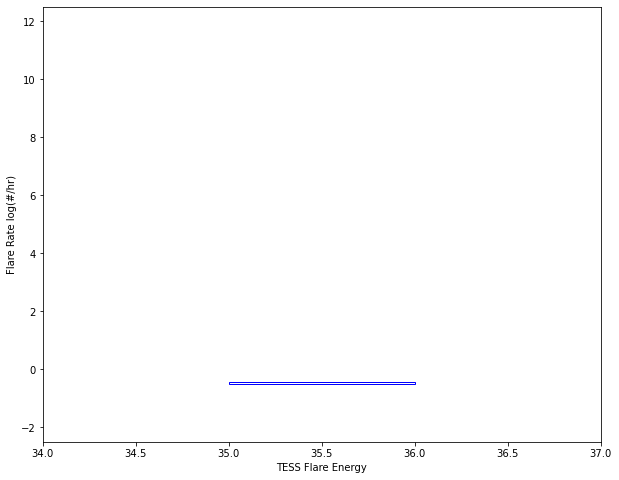

In [143]:

fig,ax=plt.subplots(1, figsize=(10, 8))
rect = Rectangle((35,rate_-rate_err), 1.0,
                 rate_+rate_err - (rate_-rate_err),
                label="AFPSC, This Work", color='b', zorder=3, fill=False)
ax.add_patch(rect)
ax.set_xlim([34., 37.])
ax.set_ylim([-2.5, 12.5])
ax.set_xlabel("TESS Flare Energy")
ax.set_ylabel("Flare Rate log(#/hr)")